## Bean Disease Identification
Beans are an important food cop in Uganda grown by small farmers.  Images of bean leaves were taken in the field in Uganda by Makerere AI lab in collaboration with National Crops Resources Research Institute.  The images were labeled healthy, bean rust, or leaf spot.  Bean rust is a fungal disease that weakens the plant and leaves it vulnerable to other diseases. The leaf spot class is unclear, but could correspond to a false positive or other bacterial/fungal infection.  Allowing farmers to use AI to quickly identify bean rust would allow them to protect their crops and provide for their families.
   
Data Source:   
https://github.com/AI-Lab-Makerere/ibean/   

Followed along with this tutorial for the pipeline:  
https://www.tensorflow.org/datasets/keras_example

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

## Data Download
Data is a stock tensorflow dataset.  Looking at the dataset info provided with it we see there are 2 disease classes and 1 healthy class.  The data is split into training, testing, and validation sets with 1034, 128, and 133 images respectively.  The images are rgb 500x500 pixels.  Inspection of the github gave the keys for converting label integers to english labels.  After unpacking the labels there are 341 to 348 instances of each class.

In [2]:
(ds_train, ds_test, ds_validation), ds_info = tfds.load(
    'beans',
    split=['train', 'test', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteQAVNG7/beans-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteQAVNG7/beans-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteQAVNG7/beans-test.tfrecord*...:   0%|          | 0/1…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_path=PosixGPath('/tmp/tmpyivu_fzbtfds'),
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <SplitInfo

In [4]:
label_conversion = {0:'Leaf Spot', 1:'Bean Rust', 2: 'Healthy'}

(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


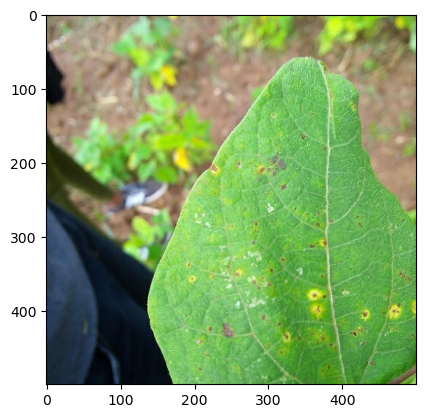

(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


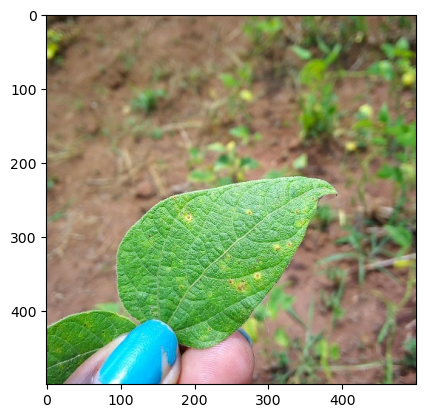

In [5]:
for image, label in ds_train.take(2):  # example is (image, label)
    print(image.shape, label)
    plt.imshow(image)
    plt.show()

In [6]:
labels = pd.Series([label for image, label in tfds.as_numpy(ds_train)])

Bean Rust    348
Leaf Spot    345
Healthy      341
dtype: int64

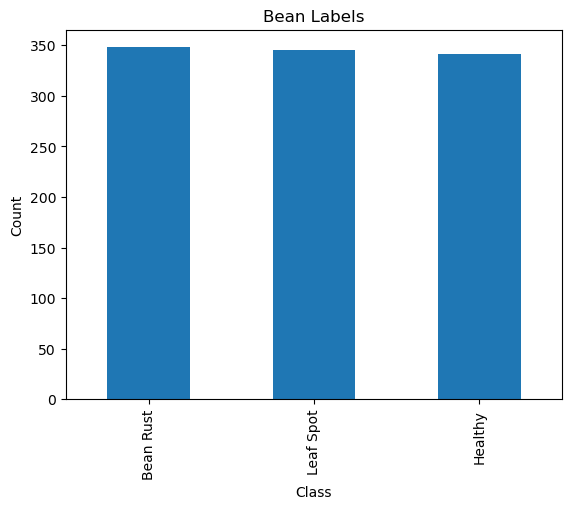

In [7]:
label_counts = labels.replace(label_conversion).value_counts()
display(label_counts)
label_counts.plot(kind='bar')
plt.title('Bean Labels')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

Creation of training and test pipelines.

In [8]:
def fn(image, label):
    return image, tf.one_hot(label, 3)

ds_train = ds_train.map(fn, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(32)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)

In [9]:
ds_test = ds_test.map(fn, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Model Construction and Training

Initial model architecture was [Conv2D, Conv2D, MaxPool2D] x 2, with 16 filters in each convolutional layer, 2x2 in the first max pool and 3x3 in the second max pool.  The layers were flattened and fed into a 16 node dense layer followed by a 3 node softmax layer for classification.  The first model had 33% test accuracy so additional convolutional layers were added using the same Conv2D, Conv2D, MaxPool architecture but varying the number of filters and size of pooling.  Most of those models suffered severe overfitting very early in training.  After doing some research it was noted that models that were successful used a [Conv2D, MaxPool2D] unit until a final layer of size 1x1xchannels.  Adopting a similar architecture gave much better results.  The first layer uses a stride of 2 to reduce the image size.  Many other published models resized first, and wanted to use a different approach.  Experimented with a hidden dense layer with dropout.  Mixed results, but the current iteration uses it.

Model architecture incorporates the preprocessing (rescaling), and training image mutations: RandomFlip, RandomRotation, RandomTranslation. The mutation layers are turned off when not training.

In [10]:
model = Sequential([
    # random flip, rotation, and translation only active when training True
    layers.Rescaling(1./255, input_shape=(500,500,3)),
    layers.RandomFlip(input_shape=(500,500,3)),
    layers.RandomRotation(.5, fill_mode='reflect'), # fraction of 2pi
    layers.RandomTranslation(.1, .1, fill_mode='reflect'), #fraction of image
    layers.Conv2D(32,3, strides = (2,2), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(32,3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(64,3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(128,3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(256,3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(512,3, activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    layers.Flatten(),
    #layers.Dense(1024, activation = 'relu'),
    #layers.Dropout(0.4),
    layers.Dense(3, activation = 'softmax')
])

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
callback=EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights=True, start_from_epoch=5)

model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics=['Accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 500, 500, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 500, 500, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 500, 500, 3)      0         
 tion)                                                           
                                                                 
 random_translation (RandomT  (None, 500, 500, 3)      0         
 ranslation)                                                     
                                                                 
 conv2d (Conv2D)             (None, 249, 249, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0

In [11]:
epochs=75
history = model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_test,
    callbacks=[callback]
)

Epoch 1/75
33/33 [==============================] - 98s 3s/step - loss: 1.0925 - Accuracy: 0.3743 - val_loss: 1.0418 - val_Accuracy: 0.4688
Epoch 2/75
33/33 [==============================] - 91s 3s/step - loss: 1.0502 - Accuracy: 0.4603 - val_loss: 0.9773 - val_Accuracy: 0.5391
Epoch 3/75
33/33 [==============================] - 90s 3s/step - loss: 0.9632 - Accuracy: 0.5580 - val_loss: 0.9828 - val_Accuracy: 0.5781
Epoch 4/75
33/33 [==============================] - 91s 3s/step - loss: 0.9980 - Accuracy: 0.5329 - val_loss: 0.9730 - val_Accuracy: 0.4688
Epoch 5/75
33/33 [==============================] - 91s 3s/step - loss: 0.9018 - Accuracy: 0.5899 - val_loss: 0.9209 - val_Accuracy: 0.5000
Epoch 6/75
33/33 [==============================] - 91s 3s/step - loss: 0.9634 - Accuracy: 0.5474 - val_loss: 0.8823 - val_Accuracy: 0.5781
Epoch 7/75
33/33 [==============================] - 90s 3s/step - loss: 0.9459 - Accuracy: 0.5648 - val_loss: 0.8415 - val_Accuracy: 0.6875
Epoch 8/75
33/33 [==

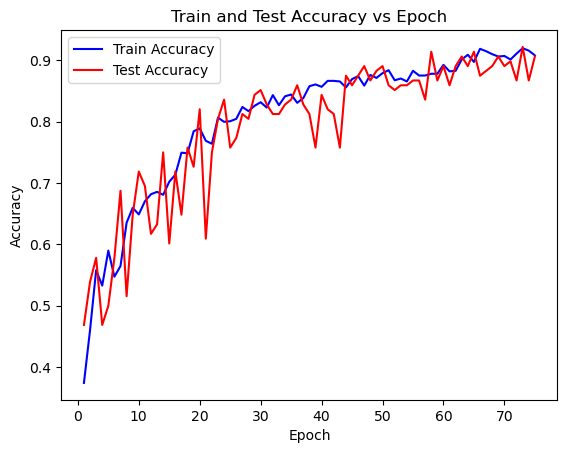

In [12]:
plt.plot(range(1,epochs+1), history.history['Accuracy'], color='b', label='Train Accuracy')
plt.plot(range(1,epochs+1), history.history['val_Accuracy'], color='r', label='Test Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs Epoch')
plt.show()

## Results

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [14]:
ds_val = ds_validation.batch(1)
y_pred = model.predict(ds_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = pd.Series([label for image, label in tfds.as_numpy(ds_validation)])
print(f'accuracy: {accuracy_score(y_true, y_pred_labels)}')

133/133 [==============================] - 3s 20ms/step
accuracy: 0.9022556390977443


Most common error confuses two diseases with brown spots for the other.  Only 1 predicted healthy when not, 2 predicted diseased when healthy.  For the simplified case of health/not healthy accuracy rises to 97.8% with 98.8% recall for diseased plants.

In [15]:
conf_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred_labels))
conf_matrix = conf_matrix.rename(index=label_conversion, columns=label_conversion)
display(conf_matrix)

,Leaf Spot,Bean Rust,Healthy
Leaf Spot,41,2,1
Bean Rust,2,35,8
Healthy,0,0,44


## Conclusion